# 2D Heat Diffusion Demo – Version 2.1

This notebook demonstrates the 2D heat equation module introduced in version **2.1** of `utility-sim-tools`.

We simulate the diffusion of a Gaussian bump in 2D using:
- Sparse Kronecker-sum Laplacian
- Explicit Euler time integration
- Periodic boundary conditions

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("../src").resolve()))

import numpy as np
import matplotlib.pyplot as plt

from numerics.laplacian_2d import make_laplacian_2d
from pdes.heat_solver_2d import run_heat_solver_2d
from utils.diagnostics import compute_l2_error

## 🧱 Grid Setup

We define a square domain of length:

$$
L = 10
$$

with a uniform grid of:

$$
N \times N \text{ points}, \quad dx = dy = \frac{L}{N}
$$

In [2]:
# Grid and domain parameters
N = 64
L = 10.0
dx = dy = L / N

x = np.linspace(-L/2, L/2, N, endpoint=False)
y = x.copy()
X, Y = np.meshgrid(x, y, indexing="ij")

## Initial Condition

We initialize a 2D Gaussian bump centered at the origin:

$$
u_0(x, y) = A \cdot \exp\left( -\frac{(x - x_0)^2 + (y - y_0)^2}{2\sigma^2} \right)
$$

In [3]:
def gaussian_bump_2d(X, Y, center=(0.0, 0.0), width=1.0, amplitude=1.0):
    x0, y0 = center
    return amplitude * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * width**2))

u0 = gaussian_bump_2d(X, Y, width=1.0)

## Construct Sparse 2D Laplacian

We build the Laplacian as a Kronecker sum:

$$
L = I_y \otimes D_x + D_y \otimes I_x
$$

where each 1D Laplacian uses periodic boundary conditions and central differences.

In [4]:
L_op = make_laplacian_2d(N, N, dx, dy)
print("Laplacian shape:", L_op.shape)

Laplacian shape: (4096, 4096)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


## Time Evolution

We solve the 2D heat equation using explicit Euler:

$$
\frac{du}{dt} = \alpha \cdot L u
$$

The solution evolves from the initial condition under periodic boundary conditions.

In [5]:
alpha = 1.0
dt = 0.01
steps = 500

u_history, diagnostics = run_heat_solver_2d(u0, L_op, alpha, dt, steps)

## Initial and Final Heat Distributions

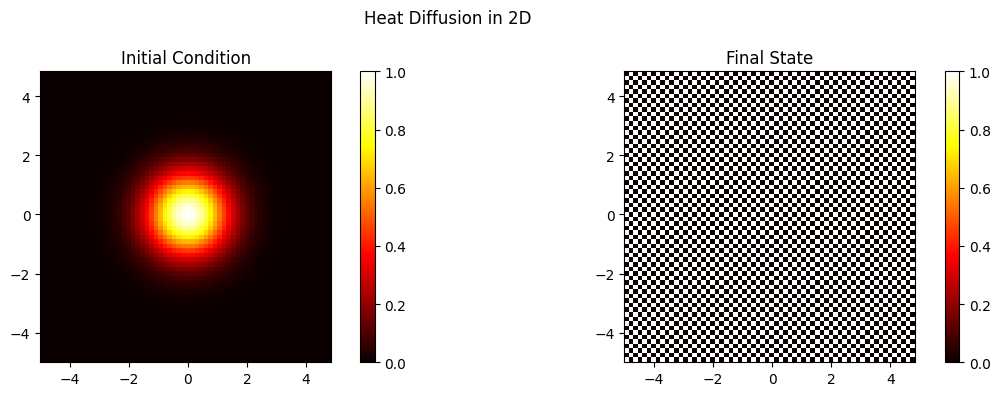

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
vmin = u_history[0].min()
vmax = u_history[0].max()

im0 = axs[0].imshow(u_history[0], origin="lower", extent=[x.min(), x.max(), y.min(), y.max()],
                    cmap="hot", vmin=vmin, vmax=vmax)
axs[0].set_title("Initial Condition")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(u_history[-1], origin="lower", extent=[x.min(), x.max(), y.min(), y.max()],
                    cmap="hot", vmin=vmin, vmax=vmax)
axs[1].set_title("Final State")
plt.colorbar(im1, ax=axs[1])

plt.suptitle("Heat Diffusion in 2D")
plt.tight_layout()
plt.show()

## Diagnostics Over Time

We track:

- Minimum
- Maximum
- Mean value

over time steps to verify diffusion behavior.

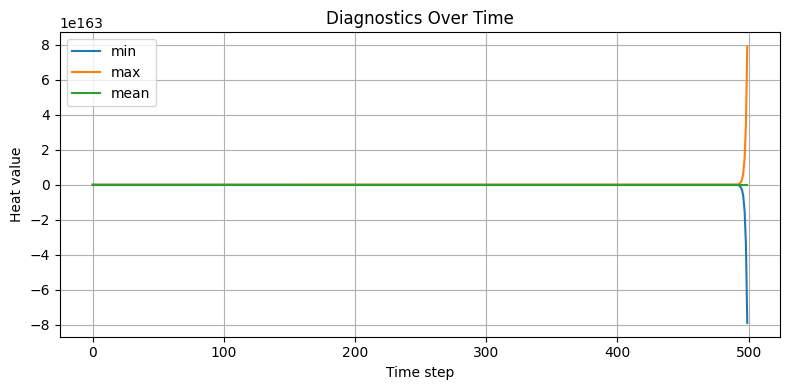

In [7]:
mins = [d["min"] for d in diagnostics]
maxs = [d["max"] for d in diagnostics]
means = [d["mean"] for d in diagnostics]
plt.figure(figsize=(8, 4))
plt.plot(mins, label="min")
plt.plot(maxs, label="max")
plt.plot(means, label="mean")
plt.xlabel("Time step")
plt.ylabel("Heat value")
plt.title("Diagnostics Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()